# Test Minimum Spanning Tree (MST)

In [53]:
# packages for graphics
import seaborn as sns
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# inline matplotlib
%matplotlib inline

In [54]:
# networks
import networkx
from networkx.drawing.nx_agraph import graphviz_layout

In [55]:
from sklearn.neighbors import KernelDensity

In [56]:
# date and time
import datetime
import dateutil
import time
from timeit import default_timer as timer

In [57]:
import numpy as np
import pandas as pd
import h5py

The data for the project is pulled using the Norgate API (https://pypi.org/project/norgatedata/) and stored in h5 files.

This notebook demonstrates how to read the h5 files for each of the instrument universes monitored in the shared h5 directory.


In [58]:
# define universe
#universe='DJI'
universe='SP100'
# define h5 input directory and file name
#inputDirectoryH5='F:/marketData/global_monitoring/premium/h5/'
inputDirectoryH5='/home/dockeruser/hosthome/DATA_698/data/'
inputFileNameH5=universe+'_premium.h5'

Open the h5 file and list the available fields:

In [59]:
# open file handle
fileHandleH5 = h5py.File(inputDirectoryH5+inputFileNameH5, 'r')
# find keys
list(fileHandleH5.keys())


['adjustedClose',
 'adjustedDividend',
 'adjustedHigh',
 'adjustedLow',
 'adjustedOpen',
 'adjustedTurnover',
 'adjustedVolume',
 'atr',
 'capitalAdjClose',
 'capitalAdjDividend',
 'capitalAdjHigh',
 'capitalAdjLow',
 'capitalAdjOpen',
 'capitalAdjTurnover',
 'capitalAdjVolume',
 'indexConstituent',
 'specialCapitalAdjClose',
 'specialCapitalAdjDividend',
 'specialCapitalAdjHigh',
 'specialCapitalAdjLow',
 'specialCapitalAdjOpen',
 'specialCapitalAdjTurnover',
 'specialCapitalAdjVolume',
 'trueRange',
 'unadjustedClose',
 'unadjustedDividend',
 'unadjustedHigh',
 'unadjustedLow',
 'unadjustedOpen',
 'unadjustedTurnover',
 'unadjustedVolume']

Read in the instrument constituent flag, the adjusted close price and true range from the h5 file:

In [60]:
# extract index constituent flag
indexConstituent = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'indexConstituent')
# extract adjusted close
price = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'adjustedClose')
# extract true range
trueRange = pd.read_hdf(inputDirectoryH5+inputFileNameH5,'trueRange')


The instrument master is not in the h5 file yet, but it eventually will just be available under another 'instrumentMaster' key.

Read instrument master:

In [61]:
# define instrument master directory and file name
inputFileMaster=universe+'.csv'
#inputDirectoryMaster='F:/marketData/global_monitoring/premium/'+universe+'/instrument_master/'
inputDirectoryMaster='/home/dockeruser/hosthome/DATA_698/data/'
# read instrument master
instrumentMaster=pd.read_csv(inputDirectoryMaster+inputFileMaster)

In [62]:
instrumentMaster.head()

,assetId,securityname,symbol,business_summary,gics_level_1,gics_level_2,gics_level_3,gics_level_4,currency,domicile
0,136817,Apple Inc Common,AAPL,"Apple Inc. designs, manufactures and markets m...",Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",USD,United States Of America
1,697433,Abbvie Inc Common,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,USD,United States Of America
2,146374,Abbott Laboratories Common,ABT,Abbott Laboratories is engaged in the discover...,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment,USD,United States Of America
3,134666,Accenture PLC Class A Common,ACN,Accenture plc is a professional services compa...,Information Technology,Software & Services,IT Services,IT Consulting & Other Services,USD,Ireland
4,141248,Adobe Inc Common,ADBE,"Adobe Inc., formerly Adobe Systems Incorporate...",Information Technology,Software & Services,Software,Application Software,USD,United States Of America


In [63]:
priceChangePercent=price.pct_change()

Compute log returns:

In [64]:
# log price by instrument
logPrice=np.log(price)
# first difference to get returns
logReturn=logPrice.diff(periods=1,axis=0)

Create a rolling version of the standardization:

In [65]:
## define standardization function
#def fStandardize2(x):
#    return (x-np.mean(x))/np.std(x)
#

In [66]:
# define standardization function
fStandardize=lambda x : (x-np.mean(x))/np.std(x)
# standardize log returns
stdLogReturn=logReturn.apply(fStandardize,axis=0)

In [67]:
## lookback
#lookback=250
## define center flag
#centerFlag=False
## standardize log returns (rolling)
#rollingStdLogReturn=logReturn.rolling(center=centerFlag,window=lookback).apply(func=fStandardize2)

Text(0, 0.5, 'Log-Return')

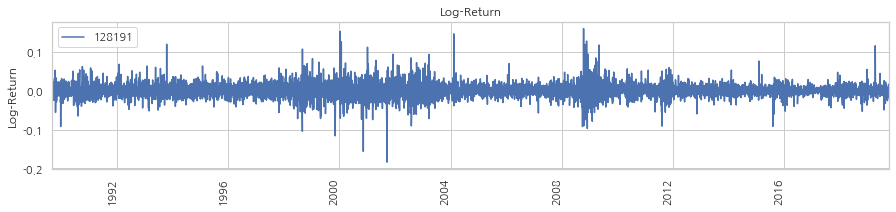

In [68]:
# define title
titleName='Log-Return'
# display the returns
priceChangePercent[128191].plot(legend=True,figsize=(15,3),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")

Text(0, 0.5, 'Log-Return')

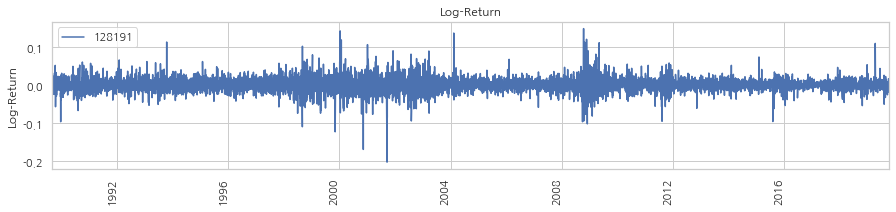

In [69]:
# define title
titleName='Log-Return'
# display the returns
logReturn[128191].plot(legend=True,figsize=(15,3),rot=90,title=titleName)
# remove x-axis label
plt.xlabel("")
# add y-axis label
plt.ylabel("Log-Return")

In [70]:
## define title
#titleName='Log-Return'
## display the returns
#rollingStdLogReturn[128191].plot(legend=True,figsize=(15,3),rot=90,title=titleName)
## remove x-axis label
#plt.xlabel("")
## add y-axis label
#plt.ylabel("Log-Return")

In [71]:
# packages for clustering
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

In [72]:
# networks
import networkx
from networkx.drawing.nx_agraph import graphviz_layout

In [73]:
# define flag to compute rolling correlations
computeRollingCorrelationsFlag=False
# define flag to compute rolling PCA
computeRollingPCA=True
# define flag to compute rolling MST (unfiltered)
computeUnfilteredMST=False
# define flag to compute rolling MST (filtered)
computeFilteredMST=False
# define the size of the rolling window in days (roughly 2 years)
lookback=250

In [74]:

# create the directory if it does not exist
#ensure_directory(outputDirectory)  

In [75]:
# 
outputDirectory=''


In [76]:
print(outputDirectory+universe+'_rollingCorrelation.h5')
print(universe+'_rollingCorrelation')

SP100_rollingCorrelation.h5
SP100_rollingCorrelation


In [77]:
if (computeRollingCorrelationsFlag):
    # start timer (compute rolling correlation)
    ts_computeRollingCorrelation = timer()    
    
    # define center flag
    centerFlag=False
    # compute centered rolling log-return correlations
    rollingCorrelation=stdLogReturn.rolling(window=lookback,
        min_periods=lookback,center=centerFlag).corr(pairwise=True)
    # create the HDF5 data store for rolling correlations (not centered)
    rollingCorrelation.to_hdf(outputDirectory+universe+'_rollingCorrelation.h5',
        'rollingCorrelation')

    # end timer (compute rolling correlation)
    te_computeRollingCorrelation = timer()
    
    # compute time elasped
    timeElasped_computeRollingCorrelation=te_computeRollingCorrelation-ts_computeRollingCorrelation
    
    # display time elasped
    print('Time Elasped: '+str(timeElasped_computeRollingCorrelation))
    
    
else:    
    # read rolling log-return correlations panel from the HDF5 results store
    rollingCorrelation = pd.read_hdf(outputDirectory+universe+'_rollingCorrelation.h5',
        'rollingCorrelation')

In [78]:
# extract datetimes
dateTimes=rollingCorrelation.index.levels[0]
# extract GICs sector tickers
tickers=rollingCorrelation.index.levels[1].values
# create weekly index (each Friday)
weeklyIndex=rollingCorrelation.index.levels[0].dayofweek==4
# extract weekly datetimes
weeklyDateTimes=dateTimes[weeklyIndex]

In [79]:
currentCorrelation=rollingCorrelation.loc[weeklyDateTimes[-1]]

In [80]:
currentCorrelation

assetId,124968,125055,125360,125597,125718,126039,126090,126228,126558,126852,...,618960,697433,946292,1500297,1565068,2073582,2073583,2176924,2314464,2505190
assetId,,,,,,,,,,,,,,,,,,,,,
124968,1.000000,0.130086,0.032624,NaN,0.149536,0.172633,0.207327,0.001346,0.016183,0.003156,...,0.009936,0.162071,NaN,0.004365,NaN,0.133695,0.061645,0.025986,0.065373,NaN
125055,0.130086,1.000000,0.441264,NaN,0.626943,0.395537,0.373320,0.358519,0.377811,0.331082,...,0.345457,0.310820,NaN,0.475769,NaN,0.154327,0.522947,0.491112,0.436228,NaN
125360,0.032624,0.441264,1.000000,NaN,0.550776,0.273777,0.374803,0.352521,0.425334,0.374827,...,0.440667,0.403926,NaN,0.475115,NaN,0.117946,0.487340,0.532427,0.388088,NaN
125597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125718,0.149536,0.626943,0.550776,NaN,1.000000,0.466480,0.591071,0.424208,0.447016,0.424287,...,0.431637,0.365570,NaN,0.511702,NaN,0.143145,0.515613,0.688781,0.540327,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073582,0.133695,0.154327,0.117946,NaN,0.143145,0.126634,0.126865,0.100494,0.067282,0.074973,...,0.074726,0.086395,NaN,0.088796,NaN,1.000000,0.118265,0.132298,0.181877,NaN
2073583,0.061645,0.522947,0.487340,NaN,0.515613,0.302845,0.409743,0.264097,0.512299,0.309557,...,0.584104,0.310855,NaN,0.648974,NaN,0.118265,1.000000,0.534367,0.357777,NaN
2176924,0.025986,0.491112,0.532427,NaN,0.688781,0.368450,0.504568,0.350762,0.466735,0.413235,...,0.456286,0.329235,NaN,0.447598,NaN,0.132298,0.534367,1.000000,0.467468,NaN


In [81]:

#
naIndex=~currentCorrelation.iloc[0].notna()



In [82]:
# define function to extract correlation for index constituents with enough historical data for datetime
def extractCorrelationForDate(rollingCorrelation,indexConstituent,datetime):
    # extract correlation for datetime
    C=rollingCorrelation.loc[dateTime]
    # find index constituents
    constituentIndex=indexConstituent.loc[dateTime]==1.0
    # extract current correlations for index constituents
    C=C.loc[constituentIndex.values,constituentIndex.values].copy()
    # create index to remove NAs (not enough historical return data)
    naIndex=C.iloc[0].notna()
    # index into current correlation matrix to exclude NAs and return
    return C.loc[naIndex,naIndex].copy()

def flattenCorrelationForDistribution(CC):
    DD=CC.copy()
    # mask the upper half of the correlation matrix including the diagonal
    DD.values[np.triu_indices(DD.shape[0])]=np.nan
    # drop upper half of correlation matrix and flatten
    return DD.unstack().dropna()


In [83]:
dateTime=weeklyDateTimes[-1]
CC=extractCorrelationForDate(rollingCorrelation,indexConstituent,datetime)

In [84]:
CC

assetId,124968,125055,125360,125718,126039,126090,126558,126966,127575,127789,...,378866,481238,525728,536372,618960,697433,1500297,2073582,2073583,2314464
assetId,,,,,,,,,,,,,,,,,,,,,
124968,1.000000,0.130086,0.032624,0.149536,0.172633,0.207327,0.016183,0.120332,0.644406,0.095798,...,0.102549,0.173193,-0.077348,0.225879,0.009936,0.162071,0.004365,0.133695,0.061645,0.065373
125055,0.130086,1.000000,0.441264,0.626943,0.395537,0.373320,0.377811,0.292009,0.204057,0.321347,...,0.558935,0.290255,0.453665,0.387653,0.345457,0.310820,0.475769,0.154327,0.522947,0.436228
125360,0.032624,0.441264,1.000000,0.550776,0.273777,0.374803,0.425334,0.181276,0.092350,0.359721,...,0.562448,0.345220,0.489979,0.405760,0.440667,0.403926,0.475115,0.117946,0.487340,0.388088
125718,0.149536,0.626943,0.550776,1.000000,0.466480,0.591071,0.447016,0.289935,0.251527,0.402108,...,0.619249,0.421190,0.552626,0.565511,0.431637,0.365570,0.511702,0.143145,0.515613,0.540327
126039,0.172633,0.395537,0.273777,0.466480,1.000000,0.430894,0.360377,0.349004,0.189217,0.245719,...,0.333759,0.428110,0.412837,0.412875,0.251325,0.271327,0.283621,0.126634,0.302845,0.334806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697433,0.162071,0.310820,0.403926,0.365570,0.271327,0.282596,0.292648,0.192922,0.279196,0.353641,...,0.384271,0.271047,0.172977,0.390774,0.262840,1.000000,0.360398,0.086395,0.310855,0.229142
1500297,0.004365,0.475769,0.475115,0.511702,0.283621,0.357388,0.592488,0.241088,0.037804,0.342826,...,0.689676,0.377976,0.464391,0.456066,0.667150,0.360398,1.000000,0.088796,0.648974,0.235741
2073582,0.133695,0.154327,0.117946,0.143145,0.126634,0.126865,0.067282,0.095983,0.084679,0.099395,...,0.063490,0.184969,0.128095,0.156819,0.074726,0.086395,0.088796,1.000000,0.118265,0.181877


Filter correlation matrix for momentum:

Convert correlation matrix to distribution:

In [85]:
flatCC=flattenCorrelationForDistribution(CC)

In [86]:
flatCC.head()

assetId  assetId
124968   125055     0.130086
         125360     0.032624
         125718     0.149536
         126039     0.172633
         126090     0.207327
dtype: float64

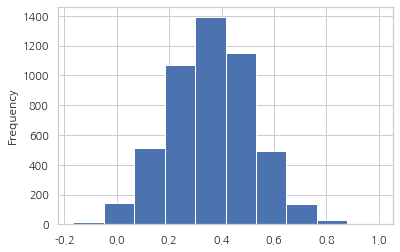

In [87]:
flatCC.plot(kind='hist')

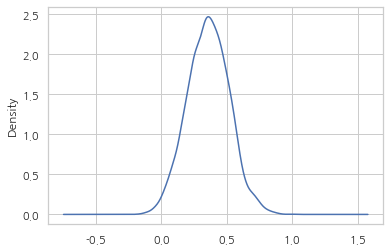

In [88]:
flatCC.plot(kind='kde')

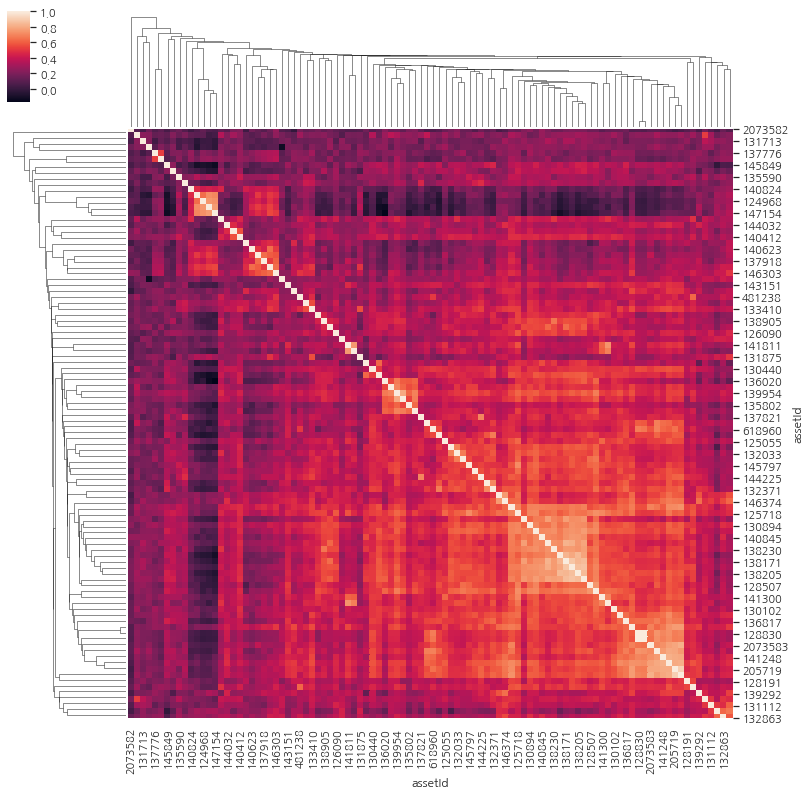

In [89]:
#
sns.clustermap(CC,method="single",linewidths=0, figsize=(13, 13))

In [90]:
def marcenkoPasturC_Q(Q):
    q = 1 / float(Q)
    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho

def marcenkoPasturC(T, N):
    q = N / float(T)
    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho

def eigenvaluePdfViaMcVsMarcenkoPastur(nDays, nInstruments,xEigenvaluesN):
    
    # find upper and lower bounds for eigenvalues and return Marcenko Pastur PDF function
    (lambdaMin, lambdaMax), rho=marcenkoPasturC(nDays, nInstruments)
    # create eigenvalue x
    xEigenvalues=np.linspace(lambdaMin, lambdaMax,xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvalues,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)
    # simulate nDays x nInstruments standardized returns
    r=np.reshape(np.random.normal(0,1,nDays*nInstruments),(nDays,nInstruments))
    # covert r to dataframe
    r=pd.DataFrame(r)
    # compute correlation matrix
    C=r.corr()
    # eigen-decomposition of correlation matrix
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # sort the eigenvalues and eigenvalues
    sortIndex=np.argsort(-eigenvalues)
    eigenvalues=eigenvalues[sortIndex]
    eigenvectors=eigenvectors[:,sortIndex]    
    
    return eigenvalues,theoreticalEigenvaluePdfDf

def plotEigenvaluePdfViaMcVsMarcenkoPastu(eigenvalues,theoreticalEigenvaluePdfDf,figureSize):
    # set figure size
    plt.figure(figsize=figureSize)
    # plot 
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])
    # plot histogram
    plt.hist(eigenvalues,bins=75,density=True)
    # add x-label
    plt.xlabel('Eigenvalue')
    # add y-label
    plt.ylabel('Frequency')
    # add title
    plt.title('Eigenvalue PDF')    
    
    return

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def shuffleDataFrame(df):
    return df.reindex(numpy.random.permutation(df.index))

def eigenvalueKdePdfBoundsViaMc(output_directory,nDays,nInstruments,nPaths,xEigenvaluesN,bandwidth,percentiles):

    dateTime=datetime.datetime.now()
    # set the HDF5 output file directory

    # create the directory if it does not exist
    ensure_directory(output_directory)    
    # create output file
    output_file='eigenvalueMC_'+str(nDays)+'_x_'+str(nInstruments)+'.h5'
    
    # find upper and lower bounds for eigenvalues and return Marcenko Pastur PDF function
    (lambdaMin, lambdaMax), rho=marcenkoPasturC(nDays, nInstruments)
    # create eigenvalue x
    xEigenvalues=np.linspace(lambdaMin, lambdaMax,xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvalues,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)

    # create matrix to store eigenvalues
    eigenvaluesByPath=np.zeros([nInstruments,nPaths])
    # create matrix to store eigenvalue KDE PDF
    eigenvaluesPdfByPath=np.zeros([xEigenvaluesN,nPaths])
    # iterate over each path
    for pathIndex in range(0,nPaths):
        # simulate nDays x nInstruments standardized returns
        r=np.reshape(np.random.normal(0,1,nDays*nInstruments),(nDays,nInstruments))
        # covert r to dataframe
        r=pd.DataFrame(r)
        # compute correlation matrix
        C=r.corr()
        # eigen-decomposition of correlation matrix
        eigenvalues, _ = np.linalg.eigh(C)
        # sort the eigenvalues and eigenvalues
        sortIndex=np.argsort(-eigenvalues)
        eigenvalues=eigenvalues[sortIndex]
        # do kernal smoothed density estimate
        pdf=kde_sklearn(eigenvalues, xEigenvalues, bandwidth=bandwidth)
        # store eigenvalue KDE PDF
        eigenvaluesPdfByPath[:,pathIndex]=pdf
        # store eigenvalues
        eigenvaluesByPath[:,pathIndex]=eigenvalues

    # percentile bounds
    eigenvalueBounds=np.percentile(eigenvaluesByPath, percentiles, axis=1).T        
    # percentile bounds
    eigenvaluePdfBounds=np.percentile(eigenvaluesPdfByPath, percentiles, axis=1).T
    # create eigenvalues by path dataframe
    eigenvaluesByPathDf=pd.DataFrame(eigenvaluesByPath)
    # create eigenvalue KDE PDF dataframe
    eigenvaluesPdfByPathDf=pd.DataFrame(eigenvaluesPdfByPath)
    # create eigenvalue bounds dataframe
    eigenvalueBoundsDf=pd.DataFrame(eigenvalueBounds,columns=percentiles)   
    # create eigenvalue KDE PDF bounds dataframe
    eigenvaluePdfBoundsDf=pd.DataFrame(eigenvaluePdfBounds,columns=percentiles)
    
    # store simulation parameters
    simulationParameters=dict()
    simulationParameters['nDays']=nDays
    simulationParameters['nInstruments']=nInstruments
    simulationParameters['nPaths']=nPaths
    simulationParameters['bandwidth']=bandwidth
    simulationParameters['xEigenvaluesN']=xEigenvaluesN
    simulationParameters['lambdaMin']=lambdaMin
    simulationParameters['lambdaMax']=lambdaMax
    #simulationParameters['percentiles']=percentiles
    # convert to dataframe
    simulationParametersDf=pd.DataFrame.from_dict(simulationParameters,orient='index')
    # set column name
    simulationParametersDf.rename(columns={0 : 'parameterValue'},inplace=True)

    # create the HDF5 data store
    data_store = pd.HDFStore(output_directory+output_file)
    # store theoretical eigenvalues dataframe
    data_store['theoreticalEigenvaluePdfDf'] = theoreticalEigenvaluePdfDf
    # store eigenvalue by path dataframe in the HDF5 data store
    data_store['eigenvaluesByPath'] = eigenvaluesByPathDf
    # store the eigenvalue KDE PDF by path dataframe in the HDF5 data store
    data_store['eigenvaluesPdfByPath'] = eigenvaluesPdfByPathDf
    # store eigenvalue bounds dataframe in the HDF5 data store
    data_store['eigenvalueBounds'] = eigenvalueBoundsDf
    # store eigenvalue KDE PDF bounds dataframe in the HDF5 data store
    data_store['eigenvaluePdfBounds'] = eigenvaluePdfBoundsDf
    # store simulation parameters dataframe
    data_store['simulationParameters'] = simulationParametersDf
    # close the HDF5 data store
    data_store.close()    
    
    return output_file,theoreticalEigenvaluePdfDf,eigenvaluesByPathDf,eigenvaluesPdfByPathDf,eigenvalueBoundsDf,eigenvaluePdfBoundsDf,simulationParametersDf

def plotActualVsTheoreticalEigenvaluePDF(nDays, nInstruments,eigenvalues,kdeFlag,figureSize):
    # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
    (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC(nDays, nInstruments)
    # actual find upper and lower bounds
    lambdaMinActual=min(eigenvalues)
    lambdaMaxActual=max(eigenvalues)
    xEigenvaluesN=len(eigenvalues)
    # create eigenvalue x (theoretical)
    xEigenvaluesActual=np.linspace(lambdaMinActual,lambdaMaxActual,xEigenvaluesN)
    # create eigenvalue x (theoretical)
    xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
        xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # KDE PDF
    pdf=kde_sklearn(eigenvalues, xEigenvaluesActual, bandwidth=0.1)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
    
    # create plot
    plt.figure(figsize=figureSize)
    # plot theoretical PDF
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])
    # if kdeFlag is set to True
    if (kdeFlag):
        # plot KDE
        plt.plot(xEigenvaluesActual,pdf)
    else:
        # plot histogram
        plt.hist(eigenvalues,bins=75,density=True)
    
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Theoretical vs. Actual Eigenvalue Distribution')
    
    return lambdaMinActual,lambdaMaxActual,lambdaMinTheoretical, lambdaMaxTheoretical

def marcenkoPasturDensityByQ(Q,xEigenvaluesN):
    
    mpDensityByQ=dict()

    for q in Q:
    
        # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
        (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC_Q(q)
        # create eigenvalue x (theoretical)
        xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
            xEigenvaluesN)
        # define Marcenko Pastur PDF lamda function 
        f = lambda x : rho(x)
        # create table to store results
        theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
        # compute theoretical PDF according to Marcenko Pastur
        # -evaluate theoretical PDF at each eigenvalue x
        theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
        # store theoretical eigenvalue pdf
        mpDensityByQ[str(q)]=theoreticalEigenvaluePdfDf
            
    return mpDensityByQ

def plotMarcenkoPasturDensityByQ(Q,xEigenvaluesN):
    
    # find theoretical upper and lower bounds for eigenvalues + return Marcenko Pastur PDF function
    (lambdaMinTheoretical, lambdaMaxTheoretical), rho=marcenkoPasturC_Q(Q)
    # create eigenvalue x (theoretical)
    xEigenvaluesTheoretical=np.linspace(lambdaMinTheoretical, lambdaMaxTheoretical,
        xEigenvaluesN)
    # define Marcenko Pastur PDF lamda function 
    f = lambda x : rho(x)
    # create table to store results
    theoreticalEigenvaluePdfDf=pd.DataFrame(xEigenvaluesTheoretical,columns=['xEigenvalues'])
    # compute theoretical PDF according to Marcenko Pastur
    # -evaluate theoretical PDF at each eigenvalue x
    theoreticalEigenvaluePdfDf['pdf']=theoreticalEigenvaluePdfDf['xEigenvalues'].apply(f)    
    
    # create plot
    plt.figure(figsize=figureSize)
    # plot theoretical PDF
    plt.plot(theoreticalEigenvaluePdfDf['xEigenvalues'],theoreticalEigenvaluePdfDf['pdf'])    
    
    return

def filterCorrelation(E,T,N):
    #    
    eigvals, eigvecs = np.linalg.eigh(E)
    #
    eigvecs = eigvecs.T
    #
    (lambda_min, lambda_max), _ = marcenkoPasturC(T, N)
    #
    xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)

    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)

    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    return E_clipped

# find nearest positive-definite matrix to input
def nearestPD(A):
    """Find nearest positive-definite matrix to input

    N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    # if positive-definite return
    if isPD(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(A))
    I = np.eye(A.shape[0])
    
    k = 1
    # while not positive-definite, apply adjustment
    while not isPD(A3):
        mineig = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = np.linalg.cholesky(B)
        return True
    except np.linalg.LinAlgError:
        return False

In [91]:
isPD(CC)

True

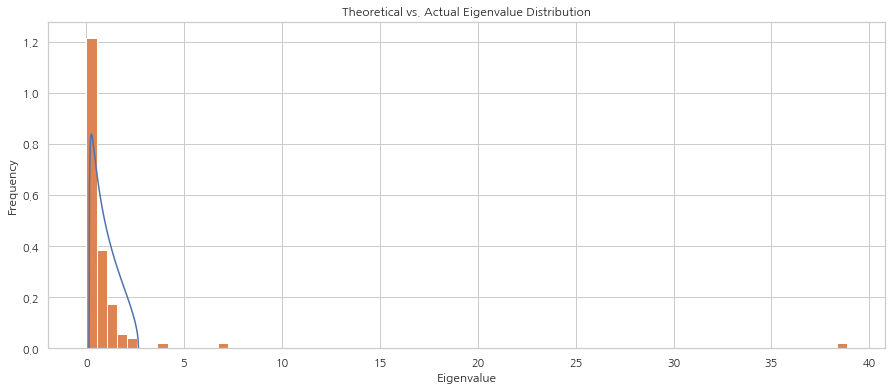

In [92]:
# define KDE flag
kdeFlag=False
# set figure size
figureSize=(15,6)
#
assetIds=CC.columns
#
nInstruments=len(assetIds)
# eigen-decomposition of full sample correlation matrix
eigenvaluesZ, eigenvectorsZ = np.linalg.eigh(CC)
# plot actual vs theoretical eigenvalue PDF
lambdaMinActualZ,lambdaMaxActualZ,lambdaMinTheoreticalZ, lambdaMaxTheoreticalZ=plotActualVsTheoreticalEigenvaluePDF(
    lookback, nInstruments,eigenvaluesZ,kdeFlag,figureSize)

Shuffle returns, recompute correlation matrix, then check the density again.

In [93]:
# define function to shuffle returns

#for columnIndex in columns:
    # shuffle index
    

In [94]:
Z=filterCorrelation(CC.values,lookback,nInstruments)

In [95]:
pd.DataFrame(Z,index=assetIds,columns=assetIds)

assetId,124968,125055,125360,125718,126039,126090,126558,126966,127575,127789,...,378866,481238,525728,536372,618960,697433,1500297,2073582,2073583,2314464
assetId,,,,,,,,,,,,,,,,,,,,,
124968,1.000000,0.120676,0.026503,0.154091,0.203377,0.195905,-0.019053,0.101288,0.508764,0.167181,...,0.069578,0.229257,-0.062046,0.145349,-0.012026,0.198282,-0.011471,0.112900,0.041345,0.045158
125055,0.120676,1.000000,0.464759,0.514082,0.385614,0.437317,0.439122,0.312288,0.160315,0.387387,...,0.499071,0.411964,0.435728,0.457581,0.423281,0.375857,0.456351,0.172000,0.470886,0.399264
125360,0.026503,0.464759,1.000000,0.499271,0.353024,0.411098,0.463659,0.301779,0.067976,0.371411,...,0.509419,0.383405,0.459396,0.442593,0.447886,0.352744,0.481667,0.148738,0.486321,0.398092
125718,0.154091,0.514082,0.499271,1.000000,0.461474,0.500659,0.445471,0.351960,0.192387,0.411440,...,0.509534,0.448223,0.487882,0.516549,0.418150,0.404055,0.455759,0.230186,0.474613,0.467845
126039,0.203377,0.385614,0.353024,0.461474,1.000000,0.418228,0.272468,0.282222,0.224380,0.301586,...,0.327476,0.349571,0.362657,0.414942,0.239485,0.307254,0.268873,0.239495,0.293017,0.388695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697433,0.198282,0.375857,0.352744,0.404055,0.307254,0.354253,0.339052,0.247040,0.231073,0.332448,...,0.405589,0.359390,0.297004,0.360699,0.335457,1.000000,0.358920,0.127131,0.380615,0.283982
1500297,-0.011471,0.456351,0.481667,0.455759,0.268873,0.358860,0.518183,0.274586,0.038682,0.386847,...,0.566571,0.380045,0.424403,0.401083,0.522237,0.358920,1.000000,0.064605,0.551708,0.327554
2073582,0.112900,0.172000,0.148738,0.230186,0.239495,0.217664,0.077966,0.141163,0.115625,0.118089,...,0.099342,0.152198,0.182420,0.208680,0.049227,0.127131,0.064605,1.000000,0.078603,0.219037


In [96]:
# sort by GICS
currentIndex=instrumentMaster['assetId'].isin(CC.columns.values)
# extract instrument master data for current components
currentInstrumentMaster=instrumentMaster.loc[currentIndex]
#

# sort instrument master
#currentInstrumentMaster=currentInstrumentMaster.sort_values(by=['gics_level_1',
#    'gics_level_2','gics_level_3','gics_level_4']).copy()

In [97]:
currentInstrumentMaster

,assetId,securityname,symbol,business_summary,gics_level_1,gics_level_2,gics_level_3,gics_level_4,currency,domicile
0,136817,Apple Inc Common,AAPL,"Apple Inc. designs, manufactures and markets m...",Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",USD,United States Of America
1,697433,Abbvie Inc Common,ABBV,AbbVie Inc. (AbbVie) is a research-based bioph...,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Biotechnology,Biotechnology,USD,United States Of America
2,146374,Abbott Laboratories Common,ABT,Abbott Laboratories is engaged in the discover...,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment,USD,United States Of America
3,134666,Accenture PLC Class A Common,ACN,Accenture plc is a professional services compa...,Information Technology,Software & Services,IT Services,IT Consulting & Other Services,USD,Ireland
4,141248,Adobe Inc Common,ADBE,"Adobe Inc., formerly Adobe Systems Incorporate...",Information Technology,Software & Services,Software,Application Software,USD,United States Of America
...,...,...,...,...,...,...,...,...,...,...
214,140824,Verizon Communications Inc Common,VZ,Verizon Communications Inc. is a holding compa...,Communication Services,Telecommunication Services,Diversified Telecommunication Services,Integrated Telecommunication Services,USD,United States Of America
216,140412,Walgreens Boots Alliance Inc Common,WBA,"Walgreens Boots Alliance, Inc., is a holding c...",Consumer Staples,Food & Staples Retailing,Food & Staples Retailing,Drug Retail,USD,United States Of America
217,128085,Wells Fargo & Co Common,WFC,Wells Fargo & Company is a bank holding compan...,Financials,Banks,Banks,Diversified Banks,USD,United States Of America
219,128310,Walmart Inc Common,WMT,"Walmart Inc., formerly Wal-Mart Stores, Inc., ...",Consumer Staples,Food & Staples Retailing,Food & Staples Retailing,Hypermarkets & Super Centers,USD,United States Of America


In [127]:
def buildInstrument2Category(instruments,categoryNames):
    # create dictionary
    instrument2Category=dict()
    # iterate over each instruments
    for i in range(0,len(instruments)):
        # extract instruments
        instrument=instruments[i]
        # extract sector
        categoryName=categoryNames[i]
        # add sector by ticker
        instrument2Category[instrument]=categoryName
    
    return instrument2Category

def buildCategory2Color(categoryNames):
    # find unique category
    uniqueCategoryNames=np.unique(categoryNames)
    # find number of category
    nCategory=len(uniqueCategoryNames)
    # set color map
    colorList=sns.color_palette("RdBu_r", nCategory)
    # define dictionary mapping category to color
    category2Color=dict()
    # iterate over sector
    for iCategory in range(0,nCategory):
        # assign color for sector
        category2Color[uniqueCategoryNames[iCategory]]=colorList[iCategory]
    
    return category2Color

def correlationNetworkColorByCategory(correlation,instruments,category2Color,instrument2Category,lookback,filterFlag=False):    
    # find number of instruments in category
    nInstruments=len(instruments)
    # create correlation graph
    category_G=networkx.Graph()
    # extract correlation matrix to a numpy array
    rho=correlation.values
    
    # if filter flag is set to True 
    if (filterFlag):
        # find RMT-based upper and lower eigenvalue bounds
        (lambda_min, lambda_max), fRho=marcenkoPasturC(lookback,nInstruments)
        # filter correlation matrix
        rho=filterCorrelation(rho,lookback,nInstruments)
        
    # check if correlation matrix is positive-definite (PD)
    pdFlag=isPD(rho)
    # if not PD, find nearest PD correlation matrix
    if (pdFlag==False):
        rho=nearestPD(rho)
    
    # iterate over each instrument
    for i in range(0,nInstruments):
        # define instrument [i]
        iInstrument=instruments[i]
        # iterate over each instrument
        for j in range(0,nInstruments):
            # define instrument [j]
            jInstrument=instruments[j]
            # compute distance
            if (rho[i,j] > 1):
                metricDistance=np.sqrt(2.0*(1.0-1.0))
            elif (rho[i,j] < -1):
                metricDistance=np.sqrt(2.0*(1.0--1.0))
            else:
                metricDistance=np.sqrt(2.0*(1.0-rho[i,j]))
                
            # build network
            category_G.add_edge(iInstrument,jInstrument,weight=metricDistance)

    # set color attributes for network nodes
    for n in category_G.nodes():
        category_G.node[n]['color']=category2Color[instrument2Category[n]]    
    
    return category_G

def minimalSpanningTreeColorByCategory(category_G,instruments,category2Color,instrument2Category):

    category_tree_seed=instruments[0]
    category_N_new=[]
    category_E_new=[]
    category_N_new.append(category_tree_seed)
    while len(category_N_new) < category_G.number_of_nodes():
        min_weight=10000000.0
        for n in category_N_new:
            for n_adj in category_G.neighbors(n):
                if not n_adj in category_N_new:
                    if category_G[n][n_adj]['weight'] < min_weight:
                        min_weight=category_G[n][n_adj]['weight']
                        min_weight_edge=(n,n_adj)
                        n_adj_ext=n_adj
        category_E_new.append(min_weight_edge)
        category_N_new.append(n_adj_ext)
    
    # generate tree from edge list
    category_tree_graph=networkx.Graph()
    category_tree_graph.add_edges_from(category_E_new)

    # set color attributes for network nodes
    for n in category_tree_graph.nodes():
        category_tree_graph.node[n]['color']=category2Color[instrument2Category[n]]
    
    return category_tree_graph

from networkx.drawing.nx_agraph import graphviz_layout

def plotMinimalSpanningTreeColorByCategory(category_G,universeName,category2Color,figureSize):
    # create position
    #category_pos=networkx.spring_layout(category_G,iterations=500,scale=10.0)
    category_pos=graphviz_layout(category_G,prog='neato')

    # define title
    titleName='Log-Return Correlation Network Minimum Spanning Tree - '+universeName
    # set figure size
    plt.figure(figsize=figureSize)
    # add title
    plt.title(titleName)
    # add edges
    networkx.draw_networkx_edges(category_G,category_pos,width=2, 
        edge_color='k', alpha=0.75) # , style="solid"
    # add labels
    networkx.draw_networkx_labels(category_G,category_pos)
    # add nodes
    for n in category_G.nodes():
        networkx.draw_networkx_nodes(category_G, category_pos, 
        [n], node_size = 600,node_color=category_G.node[n]['color'],
        with_labels=True,alpha=0.75)
        
        
    # remove axis
    plt.axis('off')
    # add legend
    legend_color_patch=list()
    # iterate over sub-industry and create patches
    for categoryName in category2Color.keys():
        categoryColor=category2Color[categoryName]
        color_patch=mpatches.Patch(color=categoryColor, 
        label=categoryName)
        legend_color_patch.append(color_patch)
    # add legend
    plt.legend(handles=legend_color_patch)
    # set tight layout
    plt.tight_layout()
    # display the graph
    plt.show()    
    
    return


In [128]:
# extract asset IDs
assetIds=currentInstrumentMaster['assetId'].values
# extract instrument tickers
instrumentTickers=currentInstrumentMaster['symbol'].values
# extract instrument names
instrumentNames=currentInstrumentMaster['securityname'].values
# extract category names
gicsL1=currentInstrumentMaster['gics_level_1'].values
# build instrument to category map
assetId2Category=buildInstrument2Category(assetIds,gicsL1)
# build category to color map
category2Color=buildCategory2Color(gicsL1)

In [129]:
assetId2Category

{136817: 'Information Technology',
 697433: 'Health Care',
 146374: 'Health Care',
 134666: 'Information Technology',
 141248: 'Information Technology',
 144053: 'Health Care',
 138905: 'Financials',
 126090: 'Financials',
 131112: 'Health Care',
 129769: 'Consumer Discretionary',
 146790: 'Financials',
 143151: 'Industrials',
 138171: 'Financials',
 131713: 'Health Care',
 141521: 'Financials',
 130440: 'Consumer Discretionary',
 145100: 'Financials',
 127789: 'Health Care',
 130894: 'Financials',
 148105: 'Financials',
 128507: 'Industrials',
 126966: 'Health Care',
 481238: 'Communication Services',
 137918: 'Consumer Staples',
 141020: 'Communication Services',
 140845: 'Financials',
 139105: 'Energy',
 133410: 'Consumer Staples',
 134176: 'Information Technology',
 129744: 'Health Care',
 142488: 'Energy',
 2314464: 'Materials',
 141877: 'Health Care',
 128191: 'Communication Services',
 143969: 'Utilities',
 146341: 'Industrials',
 127575: 'Utilities',
 136149: 'Consumer Discreti

In [130]:
category2Color

{'Communication Services': (0.11003460207612457,
  0.36262975778546713,
  0.6226066897347174),
 'Consumer Discretionary': (0.21568627450980393,
  0.5141868512110727,
  0.7328719723183391),
 'Consumer Staples': (0.4206843521722413,
  0.6764321414840445,
  0.8186851211072664),
 'Energy': (0.6549019607843136, 0.8143790849673203, 0.8941176470588235),
 'Financials': (0.8429834678969625, 0.9091118800461361, 0.9454825067281815),
 'Health Care': (0.9690888119953864, 0.9664744329104191, 0.9649365628604383),
 'Industrials': (0.9884659746251442, 0.8760476739715495, 0.8099192618223762),
 'Information Technology': (0.9686274509803923,
  0.7176470588235296,
  0.6000000000000003),
 'Materials': (0.8945790080738178, 0.5038062283737026, 0.39976931949250294),
 'Real Estate': (0.7893886966551327, 0.2768166089965398, 0.2549019607843137),
 'Utilities': (0.6461361014994232, 0.07750865051903114, 0.16032295271049596)}

Create correlation network:

In [131]:
category_G=correlationNetworkColorByCategory(CC,assetIds,category2Color,assetId2Category,
    lookback,filterFlag=False)

Create minimal spanning tree (MST):

In [132]:
category_tree_graph=minimalSpanningTreeColorByCategory(category_G,assetIds,category2Color,
    assetId2Category)

Plot minimal spanning tree:

In [134]:
#import pygraphviz
# define figure size
figureSize=(13,13)
# plot minimal spanning tree (unfiltered)
#plotMinimalSpanningTreeColorByCategory(category_tree_graph,universe,category2Color,figureSize)

AttributeError: module 'matplotlib.cbook' has no attribute 'is_string_like'

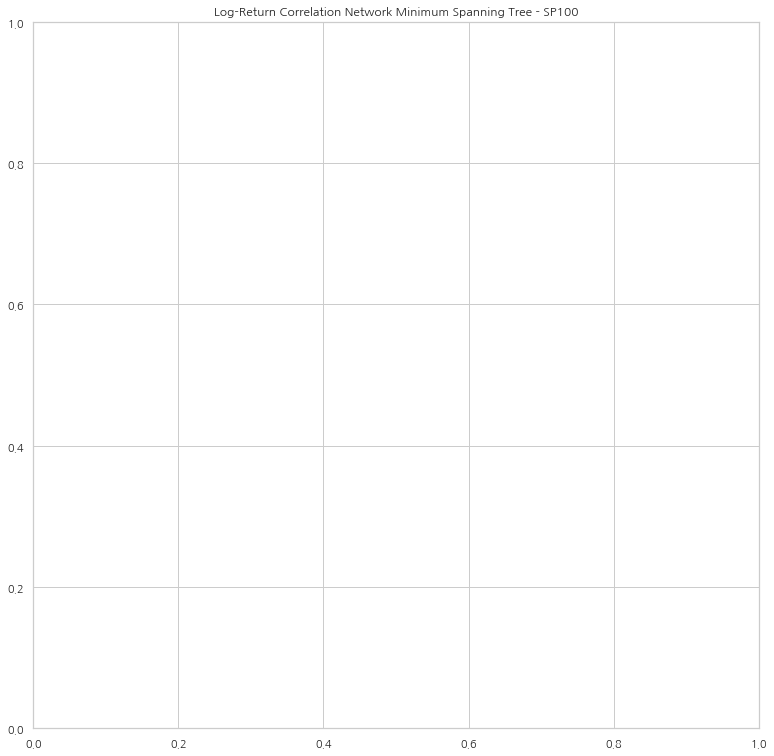

In [140]:
category_G=category_tree_graph
universeName=universe

# create position
#category_pos=networkx.spring_layout(category_G,iterations=500,scale=10.0)
category_pos=graphviz_layout(category_G,prog='neato')

# define title
titleName='Log-Return Correlation Network Minimum Spanning Tree - '+universeName
# set figure size
plt.figure(figsize=figureSize)
# add title
plt.title(titleName)
# add edges
networkx.draw_networkx_edges(category_G,category_pos,width=2) # ,edge_color='k',alpha=0.75, style="solid"
# add labels
networkx.draw_networkx_labels(category_G,category_pos)
# add nodes
for n in category_G.nodes():
    networkx.draw_networkx_nodes(category_G, category_pos, 
    [n], node_size = 600,node_color=category_G.node[n]['color'],
    with_labels=True,alpha=0.75)
        
        
# remove axis
plt.axis('off')
# add legend
legend_color_patch=list()
# iterate over sub-industry and create patches
for categoryName in category2Color.keys():
    categoryColor=category2Color[categoryName]
    color_patch=mpatches.Patch(color=categoryColor, 
    label=categoryName)
    legend_color_patch.append(color_patch)
# add legend
plt.legend(handles=legend_color_patch)
# set tight layout
plt.tight_layout()
# display the graph
plt.show()  

In [ ]:
# filtered correlation matrix
sns.clustermap(Z,method="single",linewidths=0, figsize=(13, 13),yticklabels=assetIds,
    xticklabels=assetIds)

In [ ]:
# compile these functions

# define the inverse participation ratio (IPR)
def inverseParticipationRatio(k,omega):
  # find the IPR
  IPR=np.sum(omega[:,k]**4)
  # return the IPR
  return IPR

# define the participation ratio (PR)
def PR(k,omega):
  # find the IPR
  IPR=inverseParticipationRatio(k,omega)
  # take the inverse of the IPR
  PR=1/IPR
  # return the PR
  return PR